<a href="https://colab.research.google.com/github/KurniaKhaikal/Corel-CBIR/blob/main/VGG16_CBIR_DoneFix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import json
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [2]:
from imutils import paths
import cv2
from sklearn.preprocessing import LabelBinarizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dataset = "/content/drive/MyDrive/Corel-1kNew/dataset"
class_dir = ['beaches', 'bus', 'dinosaurs',
             'elephants', 'flowers', 'foods',
             'horses', 'monuments', 'mountains_and_snow','peolpe_and_villages_in_Africa'
             ]
IMAGE_SIZE = (224, 224)

In [5]:
# indexing file images
dataset_train = []
for class_item in class_dir:
    cur_dir = os.path.join(base_dataset, 'training_set', class_item)
    for file in os.listdir(cur_dir):
        dataset_train.append(os.path.join(cur_dir, file))

In [6]:
print("train:", len(dataset_train))

train: 900


In [7]:
print("[INFO] load images Corel-Image 1k dataset...")
#  load images
train_images = []
for image_path in dataset_train:
    if ".jpg" or ".jpeg" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        train_images.append(image)

[INFO] load images Corel-Image 1k dataset...


In [9]:
# normalization
print("[INFO] normalization...")
train_x = np.array(train_images).astype("float32") / 255.0

[INFO] normalization...


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
modelVGG16 = VGG16(weights="imagenet")
model = Model(inputs=modelVGG16.input, outputs=modelVGG16.get_layer("fc1").output)
model.summary()

553476096/553467096 [==============================] - 14s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [11]:
features = model.predict(train_x)

In [12]:
indexes = list(range(0, train_x.shape[0]))
features_array = [[float(x) for x in y] for y in features]
labels = [path.split("/")[7] for path in dataset_train]
data_train = {"indexes": indexes, "features": features_array, "locations": dataset_train, "labels":labels}

In [14]:
with open('/content/drive/MyDrive/Corel-1kNew/dataset/feature_extraction1.json', 'w') as f:
    json.dump(data_train, f)

**RETRIEVAL**

In [15]:
import copy
import numpy as np
import os
import json
import cv2
import sklearn.metrics as metric
from tensorflow.keras.models import Model
import pandas as pd

In [16]:
def euclidean(a, b):
	return np.linalg.norm(a - b)

In [17]:
def perform_search(query_features, indexed_train, max_results=12):
	retrieved = []
	for idx in range(0, len(indexed_train["features"])):
		distance = euclidean(query_features, indexed_train["features"][idx])
		retrieved.append((distance, idx))
	retrieved = sorted(retrieved)[:max_results]
	return retrieved

In [18]:
base_dataset = "/content/drive/MyDrive/Corel-1kNew/dataset"
class_dir = ['beaches', 'bus', 'dinosaurs',
             'elephants', 'flowers', 'foods',
             'horses', 'monuments', 'mountains_and_snow','peolpe_and_villages_in_Africa'
             ]

IMAGE_SIZE = (224, 224)

In [19]:
# indexing file images
dataset_test = []
for class_item in class_dir:
    cur_dir = os.path.join(base_dataset, 'test_set', class_item)
    for file in os.listdir(cur_dir):
        dataset_test.append(os.path.join(cur_dir, file))

In [20]:
print("len to retrieving:", len(dataset_test))

len to retrieving: 100


In [21]:
print("[INFO] load images Corel-Image 1k dataset...")
#  load images
test_images = []
for image_path in dataset_test:
    if ".jpg" or ".jpeg" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        test_images.append(image)

[INFO] load images Corel-Image 1k dataset...


In [22]:
print("[INFO] normalization...")
test_x = np.array(test_images).astype("float32") / 255.0

[INFO] normalization...


In [23]:
from tensorflow.keras.applications import VGG16
modelVGG16 = VGG16(weights="imagenet")
model = Model(inputs=modelVGG16.input, outputs=modelVGG16.get_layer("fc1").output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
features = model.predict(test_x)

In [25]:
with open('/content/drive/MyDrive/Corel-1kNew/dataset/feature_extraction1.json') as f:
  training_indexed = json.load(f)

In [26]:
query_indexes = list(range(0, test_x.shape[0]))
label_builder = list(np.unique(training_indexed["labels"]))
class_builder = {label_unique:[] for label_unique in label_builder}
recalls = copy.deepcopy(class_builder)
precisions = copy.deepcopy(class_builder)
# loop over the testing indexes
for i in query_indexes:
    queryFeatures = features[i]
    results = perform_search(queryFeatures, training_indexed, max_results=12)
    labels_ret = [training_indexed["labels"][r[1]] for r in results]
    label_true = dataset_test[i].split("/")[7]
    label_trues = [label_true for _ in labels_ret]
    recall = metric.recall_score(label_trues, labels_ret, average='weighted')
    precision = metric.precision_score(label_trues, labels_ret, average='weighted')
    recalls[label_true].append(recall)
    precisions[label_true].append(precision)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

In [27]:
print("recall values:")
comb_recall, comb_precision = [], []
for key in recalls.keys():
    average_val = np.average(recalls[key])
    print(key, average_val)
    comb_recall.append(average_val)
print("combined recall", np.average(comb_recall))

print("\nprecision values:")
for key in precisions.keys():
    average_val = np.average(precisions[key])
    print(key, average_val)
    comb_precision.append(average_val)
print("combined precision", np.average(comb_precision))

recall values:
beaches 0.55
bus 1.0
dinosaurs 1.0
elephants 0.7583333333333333
flowers 1.0
foods 0.4333333333333334
horses 0.825
monuments 0.75
mountains_and_snow 0.775
peolpe_and_villages_in_Africa 0.6250000000000001
combined recall 0.7716666666666667

precision values:
beaches 0.9
bus 1.0
dinosaurs 1.0
elephants 1.0
flowers 1.0
foods 0.9
horses 1.0
monuments 1.0
mountains_and_snow 1.0
peolpe_and_villages_in_Africa 1.0
combined precision 0.9800000000000001


In [28]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# See https://keras.io/api/applications/ for details

class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)

        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize


In [29]:
from PIL import Image
# from feature-extractor import FeatureExtractor
from pathlib import Path
import numpy as np

if __name__ == '__main__':
    fe = FeatureExtractor()

    for img_path in sorted(Path("/content/drive/MyDrive/Corel-1kNew/image").glob("*.jpg")):
        print(img_path)  # e.g., ./static/img/xxx.jpg
        feature = fe.extract(img=Image.open(img_path))
        feature_path = Path("/content/drive/MyDrive/Corel-1kNew/feature") / (img_path.stem + ".npy")  # e.g., ./static/feature/xxx.npy
        np.save(feature_path, feature)

/content/drive/MyDrive/Corel-1kNew/image/0.jpg
/content/drive/MyDrive/Corel-1kNew/image/1.jpg
/content/drive/MyDrive/Corel-1kNew/image/100.jpg
/content/drive/MyDrive/Corel-1kNew/image/101.jpg
/content/drive/MyDrive/Corel-1kNew/image/102.jpg
/content/drive/MyDrive/Corel-1kNew/image/103.jpg
/content/drive/MyDrive/Corel-1kNew/image/104.jpg
/content/drive/MyDrive/Corel-1kNew/image/105.jpg
/content/drive/MyDrive/Corel-1kNew/image/106.jpg
/content/drive/MyDrive/Corel-1kNew/image/107.jpg
/content/drive/MyDrive/Corel-1kNew/image/108.jpg
/content/drive/MyDrive/Corel-1kNew/image/109.jpg
/content/drive/MyDrive/Corel-1kNew/image/2.jpg
/content/drive/MyDrive/Corel-1kNew/image/200.jpg
/content/drive/MyDrive/Corel-1kNew/image/201.jpg
/content/drive/MyDrive/Corel-1kNew/image/202.jpg
/content/drive/MyDrive/Corel-1kNew/image/203.jpg
/content/drive/MyDrive/Corel-1kNew/image/204.jpg
/content/drive/MyDrive/Corel-1kNew/image/205.jpg
/content/drive/MyDrive/Corel-1kNew/image/206.jpg
/content/drive/MyDrive/Cor

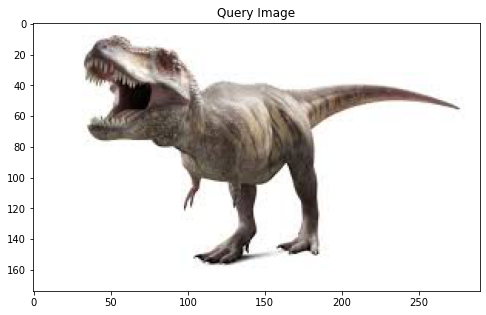

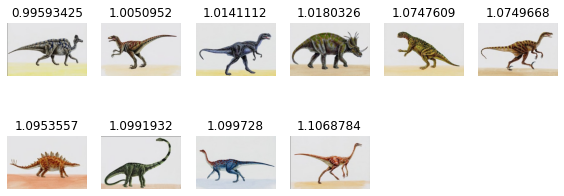

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from feature_extractor import FeatureExtractor
from datetime import datetime
from flask import Flask, request, render_template
from pathlib import Path

# Upload
img_name = "/content/drive/MyDrive/Corel-1kNew/upload/trex.jpg"
img = Image.open(img_name)

# Read image features
fe = FeatureExtractor()
features = []
img_paths = []
for feature_path in Path("/content/drive/MyDrive/Corel-1kNew/feature").glob("*.npy"):
    features.append(np.load(feature_path))
    img_paths.append(Path("/content/drive/MyDrive/Corel-1kNew/image") / (feature_path.stem + ".jpg"))
features = np.array(features)

# Run Search
query = fe.extract(img)
dists = np.linalg.norm(features-query, axis=1)  # L2 distances to features
ids = np.argsort(dists)[:10]  # Top 20 results
scores = [(dists[id], img_paths[id]) for id in ids]

# len(scores)

# Visualize

import matplotlib.image as mpimg
fig=plt.figure(figsize=(8,8))
read_image = mpimg.imread(img_name)
fig.tight_layout()
plt.title("Query Image")
plt.imshow(read_image)
plt.show()

print(" ")

axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(10):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

# max_hasil = 12
# hasil = [imgNames[index] for i,index in enumerate(rank_ID[0:max_hasil])]
# print(" ")
# fig = plt.figure(figsize=(10, 10))

# for i,im in enumerate(hasil):
#     fig.add_subplot(3, 4, i+1)
#     plt.axis('off')
#     plt.subplots_adjust(wspace=None, hspace=None)
#     img_result = mpimg.imread(base_dataset+"/"+str(im, 'utf-8'))
#     plt.title("Hasil %d" %(i+1))
#     plt.imshow(img_result)


# @app.route('/', methods=['GET', 'POST'])
# def index():
#     if request.method == 'POST':
#         file = request.files['query_img']

#         # Save query image
#         img = Image.open(file.stream)  # PIL image
#         uploaded_img_path = "static/uploaded/" + datetime.now().isoformat().replace(":", ".") + "_" + file.filename
#         img.save(uploaded_img_path)

#         # Run search
#         query = fe.extract(img)
#         dists = np.linalg.norm(features-query, axis=1)  # L2 distances to features
#         ids = np.argsort(dists)[:30]  # Top 30 results
#         scores = [(dists[id], img_paths[id]) for id in ids]

#         return render_template('index.html',
#                                query_path=uploaded_img_path,
#                                scores=scores)
#     else:
#         return render_template('index.html')


# if __name__=="__main__":
#     app.run("0.0.0.0")